# Thompson Sampling for Gaussian Bandits


Thompson sampling is a Bayesian method for exploration in reinforcement learning. Rather than selecting actions based on a single point estimate of their value, the algorithm samples action values from a posterior distribution and acts greedily with respect to the sampled values. This induces exploration naturally, without the need for an explicit exploration bonus.

In the DeepMind × UCL Reinforcement Learning Lecture Series — Exploration & Control, Thompson sampling is introduced using Bernoulli rewards for simplicity. In this notebook, we instead assume Gaussian rewards, which are more suitable for continuous-valued reward signals. Although the reward model differs, the core idea remains the same: actions are selected by sampling from the posterior distribution over their expected rewards.

Watch video form 1:43- END
you can stop before 

In [70]:
from IPython.display import IFrame

IFrame('https://www.youtube.com/embed/aQJP3Z2Ho8U?start=6180', width=800, height=450)

## Installation
First, install the required dependencies with pinned versions for reproducibility.

In [32]:
%capture
! pip install numpy==1.24.3 matplotlib==3.7.2 scipy==1.11.1

UsageError: Line magic function `%capture` not found (But cell magic `%%capture` exists, did you mean that instead?).


## Overview

**Thompson Sampling** is a smart way to solve the multi-armed bandit problem. Instead of randomly exploring (like epsilon-greedy) or using confidence bounds (like UCB), it uses a more natural approach: it tries actions based on how likely they are to be the best.

### The Core Idea

The basic idea is simple:
- For each action, keep track of what we know and **how certain** we are
- Actions we're **uncertain** about → might be good, so try them occasionally
- Actions we're **confident** are good → try them often
- Actions we're **confident** are bad → avoid them

Think of it like this: if you're unsure whether a restaurant is good, you might give it a chance. But if you've tried it many times and know it's bad, you'll avoid it.

### How It Works

In Thompson Sampling, we select the action $A_t$ at time $t$ as:

$$A_t = \arg\max_a \tilde Q_t(a),$$

where $\tilde Q_t(a)$ is a **random sample** from what we believe about action $a$.

For Gaussian rewards, we sample from:

$$\tilde Q_t(a) \sim \mathcal N\!\left(q(a)|\mu_{a,t},\,\tau_{a,t}^2\right).$$

**What this means:**
- $\mu_{a,t}$: Our best guess of action $a$'s true reward
- $\tau_{a,t}^2$: How uncertain we are (big number = very uncertain)
- As we try action $a$ more, uncertainty shrinks

### Why This Works

Thompson Sampling naturally balances exploration and exploitation:

1. **Early on (high uncertainty)**:
   - We're unsure about all actions
   - Each action occasionally looks best → gets tried

2. **Over time (learning)**:
   - Good actions: Get higher estimates, become more certain
   - Bad actions: Get lower estimates, become more certain
   - Good actions with low uncertainty → selected most often

3. **Eventually**:
   - We're confident about which action is best
   - Mostly select the optimal action
   - Still occasionally try others (but rarely)

### Advantages

**vs. Epsilon-Greedy:**
- ✅ No need to pick an epsilon value
- ✅ Exploration naturally decreases over time
- ✅ Much better performance

**vs. UCB:**
- ✅ Often works better in practice
- ✅ More flexible for complex problems

### Main Idea

Thompson Sampling achieves great performance with no parameters to tune!

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from deepmind_bandits import ThompsonSampling, GaussianBandits, BanditDataAnalyzer

# Set random seed for reproducibility
np.random.seed(42)

## Illustration: Toy Example

To build intuition, let's visualize how Thompson Sampling uses uncertainty to drive exploration.

Consider three actions with Gaussian posterior distributions:
- **Action C (Green)**: Highest mean ($\mu=2.0$), low variance ($\sigma=0.3$)
- **Action B (Orange)**: Medium mean ($\mu=1.5$), **high variance** ($\sigma=1.0$)
- **Action A (Blue)**: Lowest mean ($\mu=0.0$), low variance ($\sigma=0.3$)

**Question**: Which action should we choose?

**Greedy answer**: Always choose C (highest mean)

**Thompson Sampling's probabilistic answer**:
- C has the highest mean, so it will be sampled most often
- But B has high uncertainty — occasionally it samples values *higher* than C
- When B samples high, we select it and learn more about it
- As we observe B's rewards, its variance shrinks and we become certain whether it's better or worse than C

This is **optimism under uncertainty** in probabilistic form: we give uncertain actions a chance proportional to the probability they could be best.

In [53]:

# Three Gaussian distributions
q_ = [0.0, 1.5, 2.0]     # different means
stds = [0.3, 1, 0.3]        # same standard deviation
labels = ["A", "B", "C"]    # fixed typo: lables -> labels

env = GaussianBandits(q_, stds)



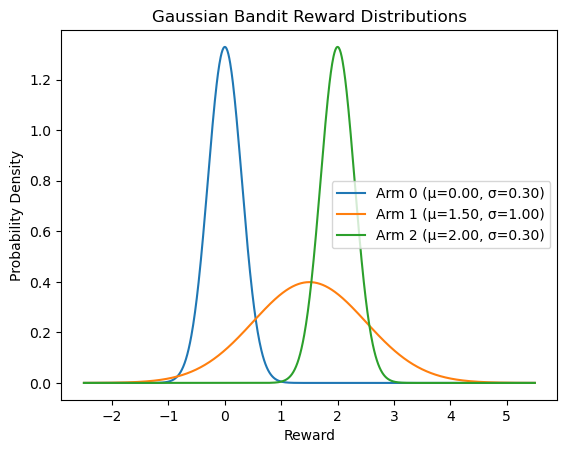

In [54]:
env.plot_parametric_distributions()

We can generate samples Although all the parameters in distribution C are larger than those of A and B, some sampled values from B still exceed those from C. For our toy example we use this function to generate samples we will set all value for $Q_0(a)=0$ for all $a$.

We can see that estimating Q amounts to computing the mean; this is simply a maximum likelihood estimation.
As rewards are observed, we update the action--value function from data. For each action $a$, the number of times it has been selected before time $t$ is
$$
n_a = \sum_{i=1}^{t-1} \mathbf 1(A_i = a),
$$
and its empirical value at time $t$ is
$$
Q_t(a)
=
\frac{1}{n_a}
\sum_{i=1}^{t-1}\mathbf 1(A_i = a)\,r_i,
\qquad n_a>0.
$$
We interpret $Q_t(a)$ as the maximum-likelihood estimate of the true value function $q(a)=\mathbb{E}[r \mid a]$.
Assuming Gaussian reward noise with variance $\sigma^2$, each reward satisfies
$$
p(r_t \mid q(a), \sigma^2)
= \mathcal N\!\bigl(r_t \mid q(a),\,\sigma^2\bigr).
$$
For a sequence of observations $\{(A_t,r_t)\}_{t=1}^{n}$, the joint likelihood under parameter $q$ is
$$
p(\{r_t\}\mid q,\sigma^2)
=
\prod_{t=1}^{n}
\mathcal N\!\bigl(r_t \mid q(A_t),\,\sigma^2\bigr).
$$
The maximum-likelihood estimate of $q$ is
$$
q^{\mathrm{MLE}}
=
\arg\max_{q}\; p(\{r_t\}\mid q, \sigma^2).
$$
For Gaussian rewards, this optimization yields the empirical mean, so that for each action
$$
q^{\mathrm{MLE}}(a) = Q_t(a).
$$
Thus $Q_t(a)$ is the value assigned to action $a$ based on data collected up to time $t$; it is not a probability, but the function used to evaluate and compare actions.

For each action $a$, we sample a value from its posterior distribution:
$$
\tilde Q_t(a) \sim p\!\left(q(a)\mid \{r_i : A_i = a\}_{i<t}\right).
$$

The selected action is the one with the highest sampled value:
$$
A_t = \arg\max_a \tilde Q_t(a).
$$

In [56]:
Q=np.zeros(len(means))
num_actions=np.ones(len(means))

Q_tilda= lambda means,std: [np.random.normal(mean,std, 1) for mean,std in zip(means,std)]
Q_tilda(means,stds)

[array([0.16737438]), array([0.14663118]), array([0.06330665])]

We sample $Q_tilda$  and then select that action then updata $Q$, the fact that $Q_tilda$ is random means it explores  

We call the arm with the highest estimated mean the 'best estimator'.

In [57]:
action = np.argmax(Q_tilda(Q,stds))

We call the arm with the highest estimated mean the 'best estimator'.

In [58]:



T=1000  # number of rounds
for t in range(T):
    # Sample one Q-value for each arm from N(mean, std)


    # Thompson sampling picks the arm with the highest sampled Q
    action = np.argmax(Q_tilda(Q,stds))
    # Take action and observe reward
    R=env.pull_arm(action)
    # Update estimated Q-value for the selected action
    Q[action] += (R - Q[action]) / (num_actions[action] + 1)
    num_actions[action] += 1





We observe that this simple algorithm converges $Q$ convers to $q$

In [59]:
print(f"Estimated Q-values: {Q} true values: {q_}")

Estimated Q-values: [0.         1.50572041 0.        ] true values: [0.0, 1.5, 2.0]


In this MLE example, we use the sample mean computed from the original dataset. In practice, however, accurately estimating the mean can be difficult when data are scarce, and the resulting algorithm may behave unreliably. Under the hood, Thompson sampling computes the probability distribution of the action–value function 
𝑄
Q given the observed data. Rather than relying on a single point estimate, it generates samples from this distribution, which leads to better action selection. These samples are more representative of the underlying uncertainty and therefore yield more robust samples

Estimation 

Recalls
In Thompson Sampling, we select the action $A_t$ at time $t$ as
$$
A_t = \arg\max_a \tilde Q_t(a),
$$
where $\tilde Q_t(a)$ is a random draw from the posterior distribution
$p(q(a)\mid \mathcal H_t)$, i.e., the distribution of the (unknown) mean reward
$q(a)$ given the history
$$
\mathcal H_t = \{(A_1,R_1),\dots,(A_{t-1},R_{t-1})\}.
$$


We need the posterior distribution of $q(a)$. Using Bayes' rule, we obtain
$$
p\bigl(q(a)\mid \mathcal H_t\bigr)
=
\frac{p\bigl(\mathcal H_t \mid q(a)\bigr)\,p\bigl(q(a)\bigr)}{p(\mathcal H_t)}.
$$

Here, $p(\mathcal H_t \mid q(a))$ is the likelihood of the observed history given $q(a)$, and $p(q(a))$ is the prior over the value of action $a$, as described above. This defines a distribution with respect to $$q(a)$$. In many applications, we can compute the posterior $p\bigl(q(a)\mid \mathcal H_t\bigr)$$; however, in Thompson sampling we are primarily interested in the fact that the samples faithfully reflect the distribution of $$q(a)$$.

We assume Gaussian reward noise with variance $\sigma^2$. Under this assumption, the likelihood term corresponding to rewards obtained from action $a$ is:




$$
p(\mathcal H_t \mid q(a))
=
\prod_{i : A_i = a} \mathcal N\!\bigl(R_i \mid q(a),\,\sigma^2\bigr),
$$
and if we choose a Gaussian prior
$$
p\bigl(q(a)\bigr) = \mathcal N\!\bigl(q(a)\mid \mu_0, \tau_0^2\bigr),
$$
then the posterior is also Gaussian:
$$
p\bigl(q(a)\mid \mathcal H_t\bigr)
= \mathcal N\!\bigl(q(a)\mid \mu_{a,t},\,\tau_{a,t}^2\bigr).
$$
In other words, a Gaussian likelihood together with a Gaussian prior over $q(a)$ gives exactly the posterior distribution $\mathcal N\!\bigl(q(a)\mid \mu_{a,t},\,\tau_{a,t}^2\bigr)$ used in Thompson Sampling.





We draw $\tilde Q_t(a)$ from the following Gaussian distribution of the action–value function:
$$
\tilde Q_t(a) \sim \mathcal N\!\left(q(a)|\mu_{a,t},\,\tau_{a,t}^2\right).
$$
The mean $\mu_{a,t}$ represents what we currently expect the reward to be for action $a$, and $\tau_{a,t}^2$ is the posterior variance for that action. Before we get into how these parameters are obtained, let us illustrate the idea with a toy example by plotting three different Gaussian curves corresponding to three different posterior means.

Consider the three distributions representing $ q(a) $ we see $\tau_{a,t} $ gets smaller as $n_a$ get larger. 

But as we continue sampling, we may eventually draw lower values from the orange distribution and then shift our selection toward the green distribution, choosing values according to that distribution instead.


the posterior parameters are
$$
\tau_{a,t}^2
=
\left(\frac{1}{\tau_0^2}+\frac{n_a}{\sigma^2}\right)^{-1},
\qquad
\mu_{a,t}
=
\frac{\frac{\mu_0}{\tau_0^2}+\frac{n_a\hat\mu_{a,t}}{\sigma^2}}
{\frac{1}{\tau_0^2}+\frac{n_a}{\sigma^2}}.
$$

**The standard deviation decreases with $$n_a$$ as more observations are collected, reflecting increased confidence in the estimated value of the action.**




$$
\mu_{a,t}=\hat\mu_{a,t}=\hat q_t(a),
\qquad
\tau_{a,t}^2=\frac{\sigma^2}{n_a}.
$$

Like in many problems the $\sigma^2$ is unknown and estimated using the pooled sample variance, 
$$
\hat\sigma^2
=
\frac{1}{\,N-1\,}\sum_{i=1}^{t-1}(r_i-\bar r)^2,
\qquad
\bar r=\frac{1}{N}\sum_{i=1}^{t-1} r_i,
\qquad
N=t-1,
$$
so that
$$
\tau_{a,t}^2\approx \frac{\hat\sigma^2}{n_a}.
$$
### Implementation Note

Our `ThompsonSampling` class:
- Uses a flat prior (no initial bias)
- Updates beliefs after each reward
- Estimates noise variance online

## Environment Setup

We create the same 4-action Gaussian bandit environment used in previous notebooks:
- Action 0: Low mean (1.0), low noise
- Action 1: **High mean (2.0), moderate noise** — optimal action
- Action 2: Negative mean (-1.0), low noise — clearly bad
- Action 3: Zero mean (0.0), high noise — unpredictable

This environment lets us compare Thompson Sampling's performance against epsilon-greedy and UCB.

In [60]:
# Create bandit environment
means = [1.0, 2.0, -1.0, 0.0]
stds = [0.1, 0.2, 0.1, 0.3]
env = GaussianBandits(means, stds)
num_actions = env.num_arms

print(f"Number of actions: {num_actions}")
print(f"True mean rewards: {means}")
print(f"Reward noise (stds): {stds}")
print(f"\nOptimal action: {np.argmax(means)} with mean reward = {max(means):.2f}")
print(f"\nGoal: Learn the optimal action through Bayesian reasoning!")

Number of actions: 4
True mean rewards: [1.0, 2.0, -1.0, 0.0]
Reward noise (stds): [0.1, 0.2, 0.1, 0.3]

Optimal action: 1 with mean reward = 2.00

Goal: Learn the optimal action through Bayesian reasoning!


## Agent Initialization

We create a Thompson Sampling agent with:
- **Flat prior** ($\tau_0^2 = \infty$): No initial bias, let data drive learning
- **Initial Q-values**: 0.0 (neutral starting point)
- **Prior mean** $\mu_0 = 0.0$: Center of flat prior (doesn't matter with $\tau_0^2=\infty$)

The agent will:
1. Maintain Gaussian posterior $\mathcal{N}(\mu_{a,t}, \tau_{a,t}^2)$ for each action
2. At each step, sample from all posteriors and select action with highest sample
3. Update posteriors based on observed rewards
4. Naturally explore uncertain actions and exploit confident good actions

In [61]:
# Create Thompson Sampling agent with flat prior
agent = ThompsonSampling(num_actions=num_actions, initial_q=0.0, tau0_var=np.inf, mu0=0.0)

# Create analyzer for tracking performance
analyzer = BanditDataAnalyzer(means, num_actions)

print(f"Agent Configuration:")
print(f"  Prior: Flat (tau0_var = inf) — no initial bias")
print(f"  Initial posterior means: {agent.means}")
print(f"  Initial posterior variances: {agent.tau}")
print(f"\nThe agent starts with maximum uncertainty about all actions.")

Agent Configuration:
  Prior: Flat (tau0_var = inf) — no initial bias
  Initial posterior means: [0. 0. 0. 0.]
  Initial posterior variances: [1. 1. 1. 1.]

The agent starts with maximum uncertainty about all actions.


## Training Loop

Now we run the Thompson Sampling algorithm for 1000 time steps. At each step:

1. **Sample from posteriors**: Draw $\tilde{Q}_t(a) \sim \mathcal{N}(\mu_{a,t}, \tau_{a,t}^2)$ for each action $a$
2. **Select action**: Choose $A_t = \arg\max_a \tilde{Q}_t(a)$ (action with highest sampled value)
3. **Observe reward**: Execute action in environment, receive reward $R_t \sim \mathcal{N}(q(A_t), \sigma^2)$
4. **Update posteriors**: 
   - Update pooled variance estimate $\hat{\sigma}^2$ with new reward
   - Update sample mean $\hat{\mu}_{A_t,t}$ for selected action
   - Recompute posterior parameters $\mu_{A_t,t+1}$ and $\tau_{A_t,t+1}^2$
5. **Track metrics**: Record for analysis

Over time, we expect:
- Posterior means $\mu_{a,t}$ to converge to true means $q(a)$
- Posterior variances $\tau_{a,t}^2$ to shrink toward zero (for frequently selected actions)
- Optimal action to be selected with increasing frequency
- Suboptimal regret growth to be logarithmic $O(\log T)$

In [62]:
T = 1000  # Number of time steps

for t in range(T):
    # Agent samples from posteriors and selects action
    action = agent.select_action()
    
    # Execute action in environment and observe reward
    reward = env.pull_arm(action)
    
    # Update posterior distributions (Bayesian inference)
    agent.update_values(action, reward)
    
    # Track performance
    analyzer.update_and_analyze(action, reward)

print(f"Training completed: {T} time steps\n")
print(f"Final Results:")
print(f"  Posterior means: {agent.means}")
print(f"  Posterior variances: {agent.tau}")
print(f"  Action selection counts: {agent.N}")
print(f"  Pooled variance estimate: {agent.pooled_var:.4f}")
print(f"\nCompare posterior means to true means: {means}")

Training completed: 1000 time steps

Final Results:
  Posterior means: [ 0.97535645  1.99458425 -1.06758791  0.10221229]
  Posterior variances: [5.74946031e-02 6.95891749e-05 8.83703057e-02 1.15348189e-01]
  Action selection counts: [  4 992   2   2]
  Pooled variance estimate: 0.0690

Compare posterior means to true means: [1.0, 2.0, -1.0, 0.0]


## Results Analysis

Let's analyze Thompson Sampling's performance and compare it to epsilon-greedy and UCB.

In [63]:
# Finalize analysis
analyzer.finalize_analysis()

### Q-Value Progression Over Time

This plot shows how posterior means (Q-values) evolved during learning:
- **Solid colored lines**: Posterior mean $\mu_{a,t}$ for each action
- **Dashed lines**: True mean rewards (ground truth)
- **Red arrows**: Action switches

**What to look for:**
- Posterior means should converge to true means (solid → dashed)
- Frequently selected actions converge faster (more data)
- Bad actions (action 2) may not converge if rarely selected (efficient!)
- Early exploration → many switches → rapid learning
- Late exploitation → few switches → stable optimal behavior

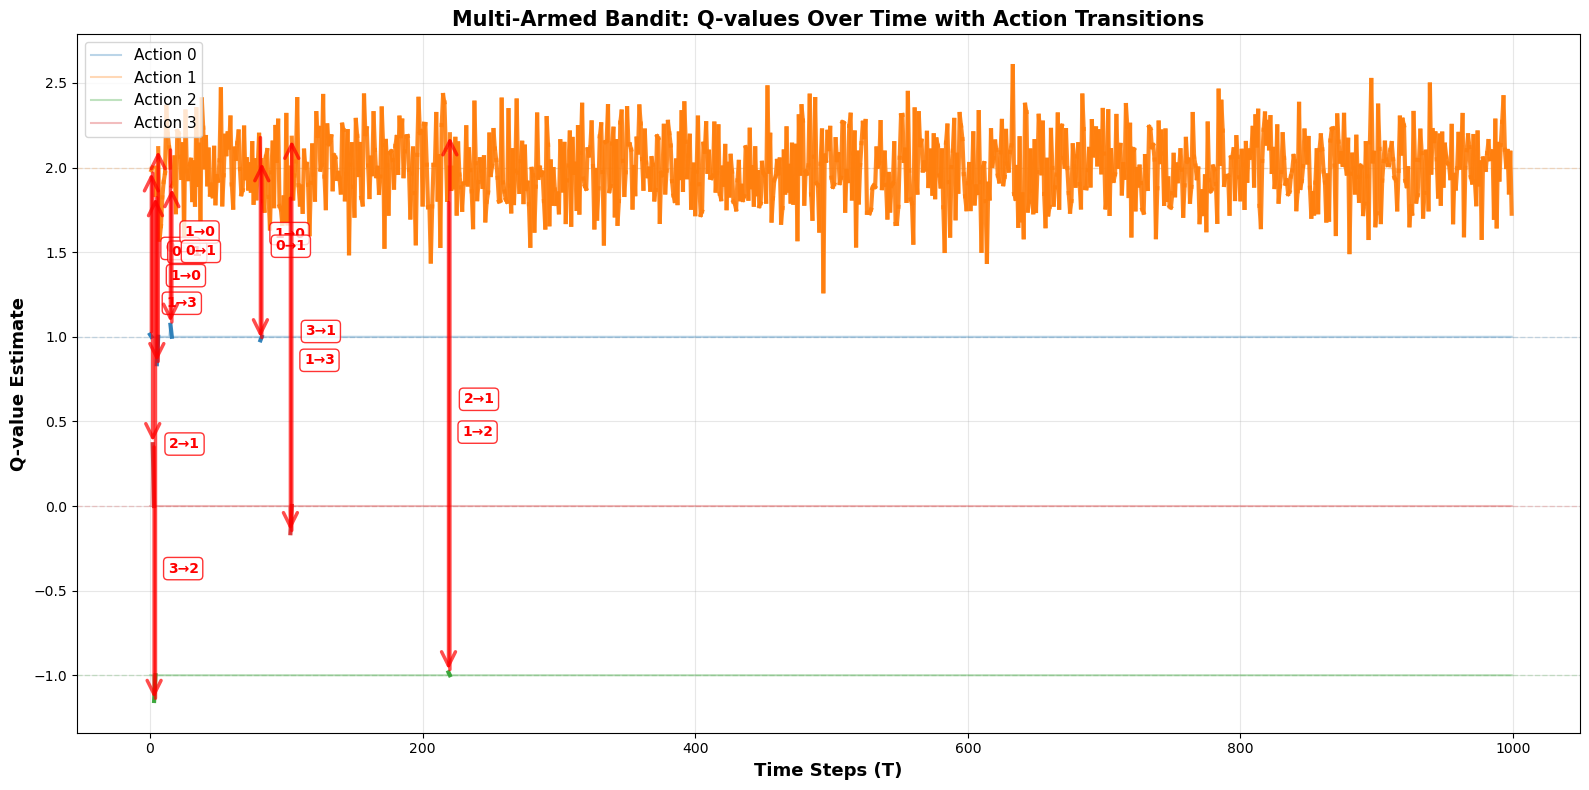


Transitions detected: 14
  Step 1: Action 0 → Action 1
  Step 2: Action 1 → Action 3
  Step 3: Action 3 → Action 2
  Step 4: Action 2 → Action 1
  Step 5: Action 1 → Action 0
  Step 6: Action 0 → Action 1
  Step 15: Action 1 → Action 0
  Step 16: Action 0 → Action 1
  Step 81: Action 1 → Action 0
  Step 82: Action 0 → Action 1
  Step 103: Action 1 → Action 3
  Step 104: Action 3 → Action 1
  Step 219: Action 1 → Action 2
  Step 220: Action 2 → Action 1


In [64]:
analyzer.plot_Qvalue()

### Cumulative Regret

**Regret** measures the total reward lost by not always selecting the optimal action:

$$\text{Regret}_T = \sum_{t=1}^{T} \left(q^* - q(A_t)\right)$$

where $q^* = \max_a q(a)$ is the optimal mean reward.

**What to look for:**
- **Slope**: Should flatten over time (sublinear growth)
- **Shape**: Logarithmic $O(\log T)$ → curve flattens significantly
- **Comparison**: 
  - Epsilon-greedy: Linear growth $O(T)$ (never stops exploring)
  - UCB: Logarithmic $O(\log T)$ (similar theoretical bound)
  - Thompson Sampling: Logarithmic $O(\log T)$ with better constants in practice

Thompson Sampling typically achieves lower regret than UCB in finite horizons due to better constant factors.

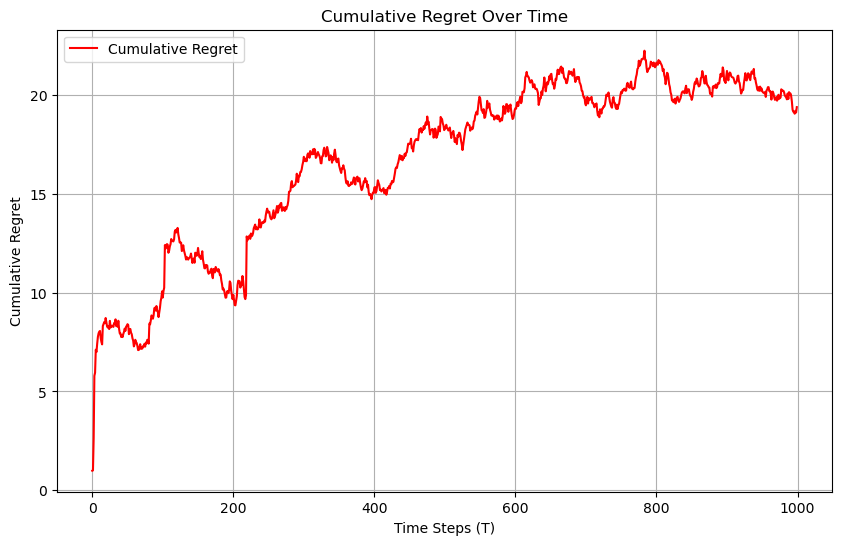

In [65]:
analyzer.plot_regret()

### Cumulative Reward

This shows total accumulated reward over time:
- **Black line**: Total cumulative reward across all actions
- **Dashed lines**: Cumulative reward per action

**What to look for:**
- Steeper slope = higher reward rate (better performance)
- Action 1's line (optimal) should dominate and have steepest slope
- Total reward should grow steadily, accelerating as we converge to optimal action
- Compare slope to theoretical maximum: $q^* \times T = 2.0 \times 1000 = 2000$

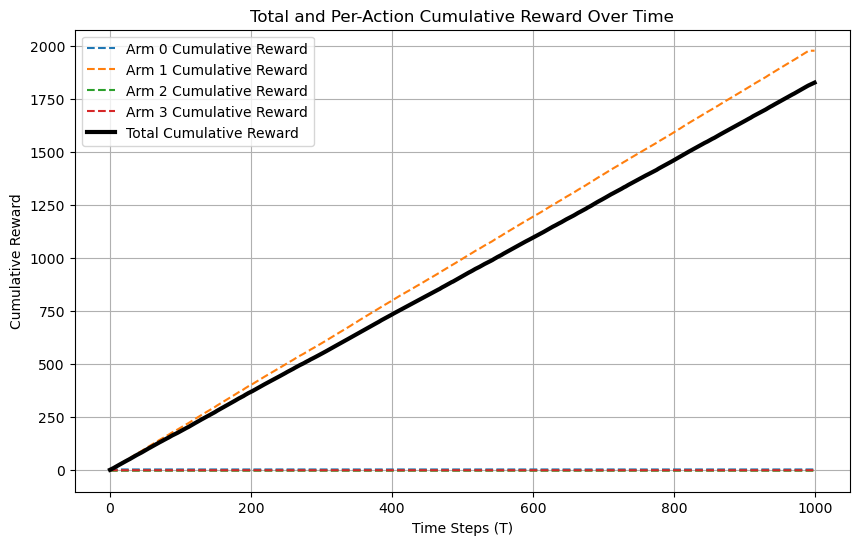

In [66]:
analyzer.plot_cumulative_reward()

## Performance Summary

In [67]:
print("=" * 60)
print("THOMPSON SAMPLING PERFORMANCE SUMMARY")
print("=" * 60)

print(f"\nExperiment Parameters:")
print(f"  Total time steps: {T}")
print(f"  Prior: Flat (uninformative)")
print(f"  Pooled variance estimate: {agent.pooled_var:.4f}")

print(f"\nLearned Posterior Distributions:")
for a in range(num_actions):
    mu = agent.means[a]
    tau_sq = agent.tau[a]
    true_mean = means[a]
    error = abs(mu - true_mean)
    count = agent.N[a]
    pct = 100 * count / T
    marker = " ← OPTIMAL" if a == np.argmax(means) else ""
    print(f"  Action {a}: μ={mu:6.3f}, τ²={tau_sq:.4f} (true={true_mean:5.2f}, error={error:.3f}) | "
          f"Selected {count:4d} times ({pct:5.1f}%){marker}")

optimal_action = np.argmax(means)
optimal_selections = agent.N[optimal_action]
optimal_pct = 100 * optimal_selections / T

print(f"\nOptimal Action Performance:")
print(f"  Optimal action: {optimal_action} (true mean = {means[optimal_action]:.2f})")
print(f"  Times selected: {optimal_selections}/{T} ({optimal_pct:.1f}%)")

if optimal_pct >= 85:  # Thompson Sampling should achieve >85% for optimal action
    print(f"  ✓ Excellent! Converged to optimal action with high probability.")
elif optimal_pct >= 70:
    print(f"  ✓ Good convergence to optimal action.")
else:
    print(f"  ⚠ Could improve - may need more time steps or different initialization.")

print(f"\nRegret Analysis:")
print(f"  Final cumulative regret: {analyzer.regret[-1]:.2f}")
print(f"  Average regret per step: {analyzer.regret[-1]/T:.3f}")
print(f"  Expected behavior: Logarithmic growth O(log T)")

print(f"\nPosterior Uncertainty:")
for a in range(num_actions):
    sigma = np.sqrt(agent.tau[a])
    print(f"  Action {a}: σ = {sigma:.4f} (std dev of posterior)")
print(f"\nLower variance = higher confidence. Rarely-selected actions retain high variance.")

print("\n" + "=" * 60)

THOMPSON SAMPLING PERFORMANCE SUMMARY

Experiment Parameters:
  Total time steps: 1000
  Prior: Flat (uninformative)
  Pooled variance estimate: 0.0690

Learned Posterior Distributions:
  Action 0: μ= 0.975, τ²=0.0575 (true= 1.00, error=0.025) | Selected    4 times (  0.4%)
  Action 1: μ= 1.995, τ²=0.0001 (true= 2.00, error=0.005) | Selected  992 times ( 99.2%) ← OPTIMAL
  Action 2: μ=-1.068, τ²=0.0884 (true=-1.00, error=0.068) | Selected    2 times (  0.2%)
  Action 3: μ= 0.102, τ²=0.1153 (true= 0.00, error=0.102) | Selected    2 times (  0.2%)

Optimal Action Performance:
  Optimal action: 1 (true mean = 2.00)
  Times selected: 992/1000 (99.2%)
  ✓ Excellent! Converged to optimal action with high probability.

Regret Analysis:
  Final cumulative regret: 19.40
  Average regret per step: 0.019
  Expected behavior: Logarithmic growth O(log T)

Posterior Uncertainty:
  Action 0: σ = 0.2398 (std dev of posterior)
  Action 1: σ = 0.0083 (std dev of posterior)
  Action 2: σ = 0.2973 (std de

## Visualize Posterior Distributions

This plot shows the **final posterior belief** about each action's reward:
- **Solid curves**: Posterior distributions $\mathcal{N}(\mu_{a,T}, \tau_{a,T}^2)$
- **Dashed vertical lines**: True mean rewards

**What to look for:**
- **Width** (variance): Narrow = high confidence, Wide = high uncertainty
- **Center** (mean): Should align with dashed line (true mean)
- **Optimal action** (action 1): Should have narrow distribution centered at 2.0
- **Rarely-selected actions**: May have wider distributions (less data)
- **Bad actions**: Should have narrow distributions centered at low values (confidently bad)

This visualization shows how Thompson Sampling's belief state drives its behavior: 
- When distributions overlap significantly → exploration still needed
- When optimal action's distribution is clearly highest and narrow → confident exploitation

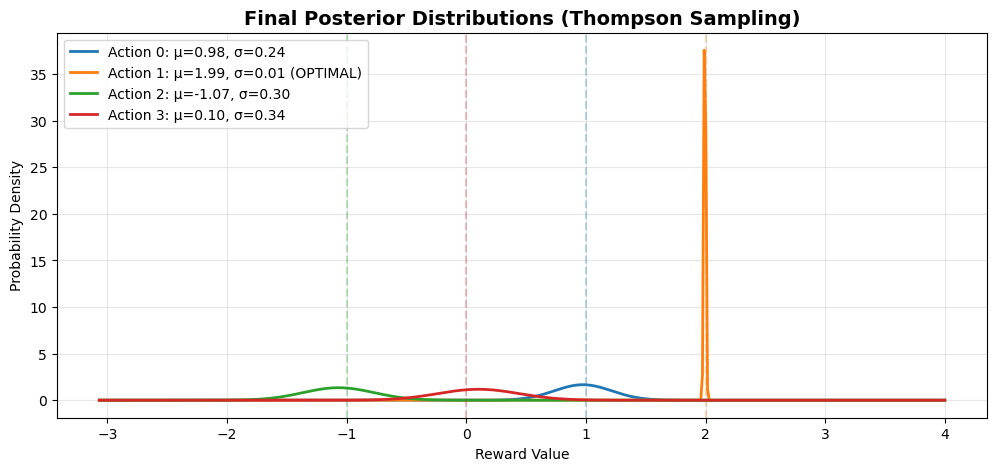

Dashed vertical lines show true means for comparison.
Narrow distributions = high confidence, Wide distributions = high uncertainty.


In [68]:
# Plot final posterior distributions
plt.figure(figsize=(12, 5))

# Determine plot range
all_means = means + list(agent.means)
x_min = min(all_means) - 2
x_max = max(all_means) + 2
x = np.linspace(x_min, x_max, 500)

for a in range(num_actions):
    mu = agent.means[a]
    sigma = np.sqrt(agent.tau[a])
    
    # Gaussian PDF
    y = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu)/sigma)**2)
    label_suffix = " (OPTIMAL)" if a == np.argmax(means) else ""
    plt.plot(x, y, label=f'Action {a}: μ={mu:.2f}, σ={sigma:.2f}{label_suffix}', linewidth=2)
    
    # Mark true mean
    plt.axvline(x=means[a], color=f'C{a}', linestyle='--', alpha=0.3, linewidth=1.5)

plt.title("Final Posterior Distributions (Thompson Sampling)", fontsize=14, fontweight='bold')
plt.xlabel("Reward Value")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Dashed vertical lines show true means for comparison.")
print("Narrow distributions = high confidence, Wide distributions = high uncertainty.")

## Sampling Behavior Demonstration

To understand how Thompson Sampling selects actions, let's simulate 10 decision steps using the final learned posteriors:

At each trial:
1. Sample once from each action's posterior: $\tilde{Q}(a) \sim \mathcal{N}(\mu_a, \tau_a^2)$
2. Select action with highest sample: $A = \arg\max_a \tilde{Q}(a)$

**What to expect:**
- Optimal action (action 1) should be selected most often (high mean, low variance)
- Occasionally other actions may be selected due to random sampling
- High-variance actions have more variable samples → occasional exploration
- This probabilistic behavior is the essence of Thompson Sampling

**Note**: This uses the *final* learned posteriors. Early in training, all actions would be selected more evenly due to high uncertainty.

In [69]:
# Demonstrate how sampling works
print("=" * 70)
print("SAMPLING FROM FINAL POSTERIORS (10 TRIALS)")
print("=" * 70)
print("\nThis demonstrates Thompson Sampling's probabilistic action selection:\n")

selection_counts = np.zeros(num_actions, dtype=int)

for trial in range(10):
    samples = []
    for a in range(num_actions):
        sample = np.random.normal(agent.means[a], np.sqrt(agent.tau[a]))
        samples.append(sample)
    
    selected = np.argmax(samples)
    selection_counts[selected] += 1
    
    samples_str = [f'{s:5.2f}' for s in samples]
    marker = " ← OPTIMAL" if selected == np.argmax(means) else ""
    print(f"Trial {trial+1:2d}: Samples = [{', '.join(samples_str)}], Selected = {selected}{marker}")

print(f"\nSelection frequency: {selection_counts}")
print(f"True optimal action: {np.argmax(means)}")
print(f"\nOptimal action selected {selection_counts[np.argmax(means)]}/10 times in this demo.")
print("=" * 70)

SAMPLING FROM FINAL POSTERIORS (10 TRIALS)

This demonstrates Thompson Sampling's probabilistic action selection:

Trial  1: Samples = [ 0.96,  1.99, -0.84, -0.01], Selected = 1 ← OPTIMAL
Trial  2: Samples = [ 0.94,  1.99, -0.98,  0.11], Selected = 1 ← OPTIMAL
Trial  3: Samples = [ 0.96,  1.99, -1.54, -0.28], Selected = 1 ← OPTIMAL
Trial  4: Samples = [ 1.15,  1.99, -1.26, -0.38], Selected = 1 ← OPTIMAL
Trial  5: Samples = [ 0.56,  1.99, -0.80, -0.09], Selected = 1 ← OPTIMAL
Trial  6: Samples = [ 1.07,  1.99, -0.88, -0.02], Selected = 1 ← OPTIMAL
Trial  7: Samples = [ 0.68,  1.99, -0.52,  0.71], Selected = 1 ← OPTIMAL
Trial  8: Samples = [ 1.09,  1.99, -0.98,  0.21], Selected = 1 ← OPTIMAL
Trial  9: Samples = [ 0.97,  2.00, -1.01, -0.01], Selected = 1 ← OPTIMAL
Trial 10: Samples = [ 0.69,  1.99, -0.83,  0.09], Selected = 1 ← OPTIMAL

Selection frequency: [ 0 10  0  0]
True optimal action: 1

Optimal action selected 10/10 times in this demo.


Created by Joseph Santacalo.
Licensed under Creative Commons Attribution (CC BY). Free to share and adapt with attribution.